In [1]:
import sys # for automation and parallelization: set manual to false when run by a launcher
manual, scenario = (True, 'base') if 'ipykernel' in sys.argv[0] else (False, sys.argv[1])

# Road Pathfinder with Capacity Contraints

In [2]:
import sys
sys.path.insert(0, r'../../../quetzal')
from quetzal.model import stepmodel
import pandas as pd

PyTables is not installed. No support for HDF output.


In [3]:
training_folder = '../../'
plot_path = training_folder + 'outputs/plot/'

In [4]:
sm = stepmodel.read_zippedpickles(training_folder + r'models/{scen}/aon_pathfinder'.format(scen=scenario))
distribution = stepmodel.read_zippedpickles(training_folder + r'models/{scen}/distribution'.format(scen=scenario))
sm.volumes = distribution.volumes

volumes: 100%|██████████| 3/3 [00:00<00:00, 1007.20it/s]


In [5]:
# Each link can have its own capacity
sm.road_links['capacity'] = 2000

# Keep relevant OD
v = sm.volumes.set_index(['origin', 'destination'])["car_owner"]
od_set = set(v.loc[v>1].index)

# Iterative Road Patfinder

In [6]:
constrained = sm.copy()
free = sm.copy()

constrained.step_road_pathfinder(
    method='BFW',
    tolerance=1.0,
    maxiters=50,
    od_set=od_set,
    volume_column='car_owner',
    log=True,
    num_cores=1,
    access_time='time',
    path_analysis=False
)

vdf not found in road_links columns. Values set to 'default_bpr'
alpha not found in road_links columns. Values set to 0.15
beta not found in road_links columns. Values set to 4
limit not found in road_links columns. Values set to 20
penalty not found in road_links columns. Values set to 0
iteration | Phi |  Rel Gap (%)
0 0.1656 60.007
1 0.1453 36.16
2 0.1344 19.35
3 0.1484 9.839
4 0.1625 4.866
5 0.1875 2.539
6 0.8 1.609
7 0.8 0.27


# Export 

In [7]:
constrained.to_zippedpickles(training_folder + 'models/{scen}/constrained_road_pathfinder'.format(scen=scenario))

  0%|          | 0/33 [00:00<?, ?it/s]

relgap: 100%|██████████| 33/33 [00:02<00:00, 12.85it/s]                   


# PLOT

In [8]:
if manual:
    constrained.analysis_car_los()
    constrained.car_los[('car_owner', 'probability')] = 1
    constrained.step_car_assignment(volume_column='car_owner')

    free.analysis_car_los()
    free.car_los[('car_owner', 'probability')] = 1
    free.step_car_assignment(volume_column='car_owner')
    free.road_links['flow'] = free.road_links[('car_owner', 'car')].fillna(0)

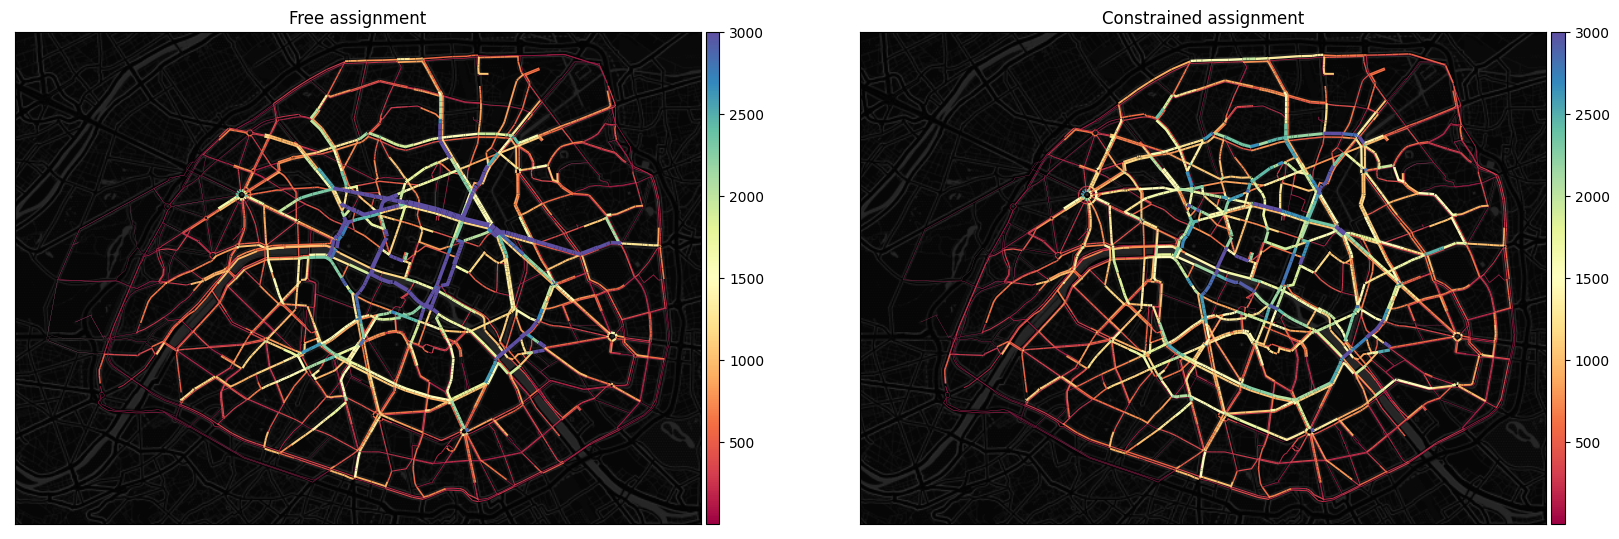

In [9]:
if manual:
    import matplotlib.pyplot as plt
    %matplotlib inline
    fig, axes = plt.subplots(ncols=2, sharey=True, sharex=True, figsize=[20, 20])

    axes[0].set_aspect('equal')
    axes[1].set_aspect('equal')

    from syspy.syspy_utils import data_visualization as dv
    bandwidth = dv.bandwidth
    power=0.5
    lv = [100, 1000, 2000, 5000, 7000]

    url = 'http://a.basemaps.cartocdn.com/dark_nolabels/tileZ/tileX/tileY.png'
    plot = bandwidth(
        free.road_links.loc[free.road_links['flow'] > 0], value_column='flow',
        power=0.5, figsize=[25, 15], ax=axes[0], max_value=3000
    )
    dv.add_basemap(plot, url=url, zoom=12)
    plot.set_title("Free assignment")
    plot = bandwidth(
        constrained.road_links.loc[constrained.road_links['flow'] > 0], value_column='flow',
        power=0.5, figsize=[25, 15], ax=axes[1], max_value=3000
    )
    dv.add_basemap(plot, url=url, zoom=12)
    plot.set_title("Constrained assignment")
    fig.tigh_layout=True

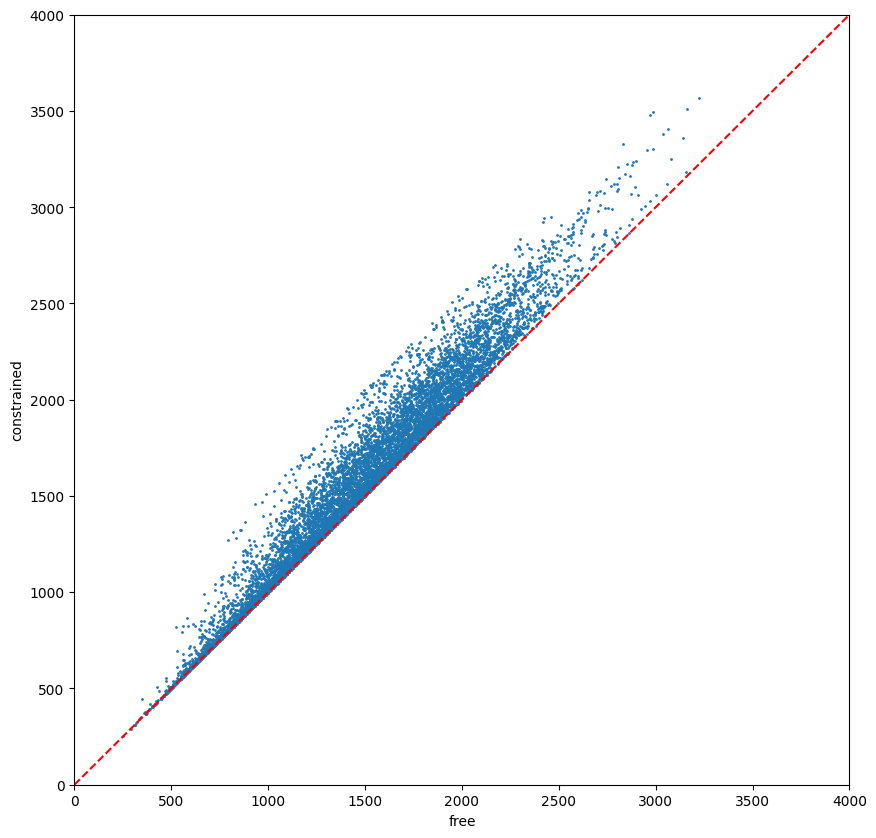

In [10]:
if manual:
    import pandas as pd
    c = constrained.car_los.groupby(['origin', 'destination'])['time'].min()
    f = free.car_los.groupby(['origin', 'destination'])['time'].min()
    df = pd.DataFrame([c, f], index=['constrained', 'free']).T
    df.plot(kind='scatter', y='constrained', x='free', figsize=[10, 10], s=1)
    plt.plot([0, 4000], [0, 4000], color='red', linestyle='--')
    # square plot
    plt.xlim([0, 4000])
    plt.ylim([0, 4000])